# 18.330 Problem set 3 (spring 2020)

## Submission deadline: 11:59pm on Tuesday, February 25


#### Exercise 1: Algorithmic differentiation

1. Complete the implementation of the `Dual` type from class,
including derivatives for subtraction, division, and integer powers.
For $/$ you may assume that the denominator is not zero.

    Add methods for each function to e.g. add a real number (type `::Real`) to a `Dual`.
    Treat a real number as having derivative 0.

2. Put these definitions in a file `dual.jl`.
This may be included with `include("dual.jl")`
from Juno or Jupyter, or from another file.

    (You must make sure the files are in the same directory,
    or give the path to the file on your machine.)

3. For functions $f$ such as `exp`, we define the action of the
function on a `Dual` using

    $$f(a + b\epsilon) = f(a) + \epsilon \, b f'(a)$$

    Use this to define `exp`, `sin` and `log` on `Dual` numbers.

4. Write a function `derivative` that takes a function $f$ and a
point $a$, and uses `Dual` numbers to calculate the derivative
$f'(a)$ of $f$ at $a$. It should return *only* the derivative.

5. Define a function to calculate the directional derivative of a
function $f:\mathbb{R}^n \to \mathbb{R}$ in a direction $\mathbf{v}$.

6. Use this to write a function `partial` to calculate the $i$th
partial derivative of a function.

7. Write functions to calculate the gradient and Jacobian
of a function $f: \mathbb{R}^n$.

8. Write a few tests of the functions you have written.
Use simple functions for which you can do the calculations by hand to write the tests.

### Dual type and operation 

In [25]:
struct Dual{T<:Real}
    value::T
    deriv::T
end
Dual(a, b) = Dual(promote(a, b)...)

Dual

In [41]:
import Pkg; Pkg.add("ForwardDiff")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  99.9 %34.2 %Fetching: [============================>            ]  68.4 %Fetching: [===============================>         ]  75.8 %Fetching: [=====================================>   ]  91.4 %Fetching: [=======================================> ]  95.3 %Fetching: [=======================================> ]  95.5 %Fetching: [=======================================> ]  95.7 %Fetching: [=======================================> ]  96.4 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
  [f6369f11] + ForwardDiff v0.10.14
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.0.3
  [b552c78f] + DiffRules v1.0.2
  [f6369f11] + ForwardDiff v0.10.14


In [42]:
import Base: +, -, *, /, ^, ==, exp, sin, log
using Test
using ForwardDiff

In [9]:
+(a::Dual, b::Dual) = Dual(a.value + b.value, a.deriv + b.deriv)
+(a::Dual, b::Real) = Dual(a.value + b, a.deriv)
+(a::Real, b::Dual) = Dual(a + b.value, b.deriv)

+ (generic function with 169 methods)

In [10]:
-(a::Dual, b::Dual) = Dual(a.value - b.value, a.deriv - b.deriv)
-(a::Dual, b::Real) = Dual(a.value - b, a.deriv)
-(a::Real, b::Dual) = Dual(a - b.value, - b.deriv)

- (generic function with 177 methods)

In [11]:
*(a::Dual, b::Dual) = Dual(a.value * b.value, a.deriv * b.value + a.value * b.deriv)
*(a::Dual, b::Real) = Dual(a.value * b, a.deriv * b)
*(a::Real, b::Dual) = Dual(a * b.value, b.deriv * a)

* (generic function with 360 methods)

In [14]:
/(a::Dual, b::Dual) = Dual(a.value / b.value, (a.deriv * b.value - a.value * b.deriv)/b.value^2)
/(a::Dual, b::Real) = Dual(a.value / b, a.deriv / b)
/(a::Real, b::Dual) = Dual(a / b.value, -a * b.deriv / b.value^2)

/ (generic function with 118 methods)

In [31]:
^(a::Dual, b::Real) = Dual(a.value ^ b, b * a.value^(b-1) * a.deriv)
^(a::Real, b::Dual) = Dual(a ^ b.value, log(a) * a^b.value)

^ (generic function with 68 methods)

In [15]:
==(a::Dual, b::Dual) = a.value == b.value && a.deriv == b.deriv

== (generic function with 157 methods)

In [34]:
exp(a::Dual) = Dual(exp(a.value), a.deriv * exp(a.value))

exp (generic function with 14 methods)

In [35]:
sin(a::Dual) = Dual(sin(a.value), a.deriv * cos(a.value))

sin (generic function with 13 methods)

In [36]:
log(a::Dual) = Dual(log(a.value), a.deriv / a.value)

log (generic function with 20 methods)

##### Unit Tests

In [39]:
a = 2
xx = Dual(a, 1)
f1(x) = 1 + x + x + 3
f2(x) = 1 - x - 2
f3(x) = 3*x*x*2
f4(x) = x*x*x/x
f5(x) = x^4
f6(x) = 3^x
f7(x) = exp(x^2)
@test f1(xx) == Dual(8, 2)   # test +
@test f2(xx) == Dual(-3, -1) # test -
@test f3(xx) == Dual(24, 24) # test *
@test f4(xx) == Dual(4, 4)   # test /
@test (x->1/x)(xx) == Dual(0.5, -0.25)
@test (x->x/2)(xx) == Dual(1, 0.5)
@test f5(xx) == Dual(16, 32) # test ^
@test f6(xx) == Dual(9, 9*log(3))
@test f7(xx) == Dual(exp(4), 4*exp(4)) # test exp
@test (x->sin(x^2))(xx) == Dual(sin(4), 4*cos(4)) # test sin
@test (x->log(x^2))(xx) == Dual(log(4), 1) # test log

Test Passed

#### Exercise 2: Newton for higher-dimensional functions

1. Implement the multidimensional Newton method. It should take a function $f$
and an initial guess $x_0$.

    You should preferably use your own function from [Exercise 1] for
    calculating the Jacobian. You may also use instead the function
    `ForwardDiff.jacobian` from the `ForwardDiff.jl` package.

    You should first do a basic check that $f$ does the right thing
    by checking if $f(x_0)$ is of the same dimension as $x_0$.

    Iterate until the residual is small enough or until some maximum
    number of iterations is reached. To check the residual, use
    the `norm` function from the standard library `LinearAlgebra` package.
    This calculates the "size" (length) of a vector.

    The function should return a pair `(flag, r)`, where `flag`
    is a Boolean that indicates if a root was found, and `r` is the location
    of the root (if one was found).


2. Consider the nonlinear system

    \begin{align}
    x^2 + y^2 = 3  \\
    \left(\frac{x}{2} \right)^2 + (y-a)^2 = 1
    \end{align}


    Make a plot of the two functions for $a = 0.5$.
    How many roots are there?

3. From your plot, identify by eye approximately where the top right root is.
Use the Newton method to find it accurately.

    Find the order of convergence of the method in this case.
    (As usual you probably need `BigFloat` to get a good result.)

4. Make a function `all_roots` that searches for all roots in a given
rectangular box. (The size of the box should be given as arguments to the function).
It should keep a list of the *unique* roots found so far (i.e. without duplicates).
Use a tolerance to decide if two roots are the same or not.

    You may use a grid search or a random search inside the box.

5. Use `all_roots` to find all solutions of the system.

6. Make an interactive visualization where you repeat the above for different values of $a$.
You should redraw the curves and draw all roots you find on top, for each value of $a$.

    Which qualitative change occurs and why? How could you think of
    going about finding numerically the critical value of $a$ for which
    this happens? You do not need to do so, just think about what you *would*
        do.

    Extra credit if you actually do so.

In [59]:
using LinearAlgebra

In [165]:
clamp.([-2, 3], -1, 2)

2-element Array{Int64,1}:
 -1
  2

In [166]:
function multi_dim_newton(f, x₀, max_iter=100, ϵ=1e-9)
    @assert length(f(x₀)) == length(x₀)
    x_old = x₀
    xn = []
    iter_num = 0
    while true
        x_new = x_old - clamp.(ForwardDiff.jacobian(f, x_old) \ f(x_old), -2, 2) 
        push!(xn, x_new)
        iter_num += 1 
        if norm(x_new - x_old) < ϵ || iter_num >= max_iter
            break
        end
        x_old = x_new
    end
    return (iter_num != max_iter, xn[end])
end

multi_dim_newton (generic function with 3 methods)

In [174]:
function internal_rand(a, b)
    return rand()*(b-a) + a
end

function all_roots(f, x_min, x_max, y_min, y_max, ϵ=1e-9, rand_start = 10)
    @assert x_min < x_max && y_min < y_max
    roots = []
    for i in 1:rand_start
        x = internal_rand(x_min, x_max)
        y = internal_rand(y_min, y_max)
        (flag, root) = multi_dim_newton(f, [x, y])
        if root[1] < x_min || root[1] > x_max || root[2] < y_min || root[2] > y_max
            continue
        end
        if flag
            new_root = true
            for i in 1:length(roots)
                if norm(roots[i] - root) < ϵ
                    new_root = false
                    break
                end
            end
            if new_root
                push!(roots, root)
            end
        end
    end
    return roots
end

all_roots (generic function with 3 methods)

In [168]:
using Plots

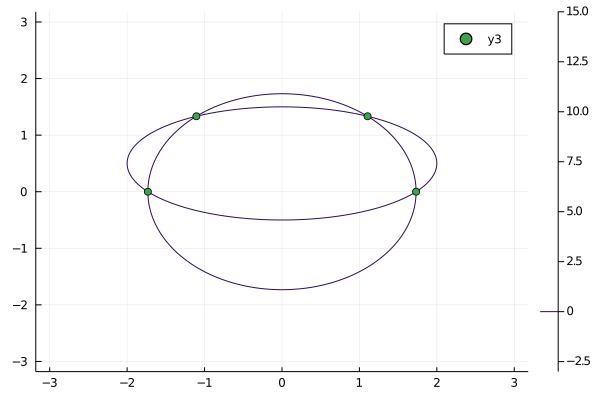

In [169]:
a = 0.5
f₁ = (x, y) -> x^2 + y^2 - 3
f₂ = (x, y) -> (x/2)^2 + (y-a)^2 - 1
contour(-3:0.01:3, -3:0.01:3, f₁, levels = [0])
contour!(-3:0.01:3, -3:0.01:3, f₂, levels = [0])
roots = all_roots(x->[f₁(x...), f₂(x...)], -3, 3, -3, 3)
rootx = [roots[i][1] for i in 1:length(roots)]
rooty = [roots[i][2] for i in 1:length(roots)]
scatter!(rootx, rooty)

#### Exercise 3: A more complicated example

Consider the system

\begin{align}
(x+3) (y^3-7) + 18 = 0 \\
\sin(y \exp(x)-1)) = 0
\end{align}

(taken from [here](https://github.com/JuliaNLSolvers/NLsolve.jl)).


1. Draw plots of the two functions.

2. Find as many roots as you can in the region $[-5, 5]^2$. How many are there?

3. Plot them on top of the graph. Did you find them all?

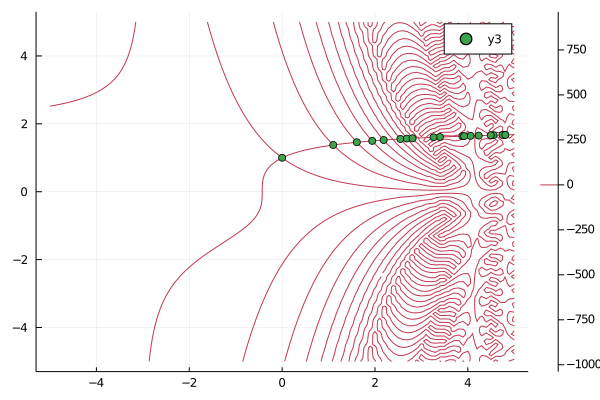

In [175]:
f₁ = (x, y) -> (x + 3)*(y^3 - 7) + 18
f₂ = (x, y) -> sin(y * exp(x) - 1) 
contour(-5:0.1:5, -5:0.1:5, f₁, levels = [0])
contour!(-5:0.1:5, -5:0.1:5, f₂, levels = [0])
roots = all_roots(x->[f₁(x...), f₂(x...)], -5, 5, -5, 5, 1e-9, 100)
rootx = [roots[i][1] for i in 1:length(roots)]
rooty = [roots[i][2] for i in 1:length(roots)]
scatter!(rootx, rooty)

#### Exercise 4: Lorenz equations

 The [Lorenz equations](https://en.wikipedia.org/wiki/Lorenz_system)
are a system of 3 ordinary differential equations that give a "simple"
model of convection in the atmosphere. They are famous since their solutions
form beautiful patterns and are an early example of the identification of **chaos**
in deterministic dynamical systems:


\begin{align}
\frac{\mathrm{d}x}{\mathrm{d}t} &= \sigma (y - x), \\[6pt]
\frac{\mathrm{d}y}{\mathrm{d}t} &= x (\rho - z) - y, \\[6pt]
\frac{\mathrm{d}z}{\mathrm{d}t} &= x y - \beta z.
\end{align}


We will take the standard parameter values: $\sigma = 10$ and $\beta = 8/3$.


We will come back to look at their dynamics later in the course. For now we
will look only at the **stationary points**, which are obtained by setting all of
the time derivatives equal to $0$ and solving the resulting system
of nonlinear equations. [If the system starts at a stationary point,
it will remain there.]

[Note that for this particular system the roots may be found analytically, which
you may use to check your work. But if you were to perturb the
original system a bit, it would no longer be possible to find the roots analytically.]

1. Make a function `lorenz(x, y, z, σ, ρ, β)` and a method
`lorenz(ρ)` that takes a vector `x` and uses the standard parameter values.
for $\sigma$ and $\beta$.

2. Make a function `all_roots3` that is a 3D version of `all_roots`.
[Extra credit: Make a generic version that works in *any* number of dimensions.]

3. Use `all_roots3` to find all the stationary points for $\rho = 2$. You should
search in a box $[-5, 5]^3$.
How many stationary points are there?


The **stability** of a stationary point turns out to be given by the eigenvalues of
the Jacobian matrix at that point. [A trajectory starting close
to an unstable point will move away from that point.]
We will see how to calculate eigenvalues of
a matrix later in the course; for now, use the `eigvals` function from `LinearAlgebra`.
Recall that the eigenvalues of a matrix are complex numbers in general.

A stationary point is **stable** if the real part of each eigenvalue is $<0$, and
**unstable** if any eigenvalue has real part $>0$.

4. Write a function `maximum_stability(f, x)` that calculates the maximum of the real parts
of all the eigenvalues,
assuming that $x$ is a stationary point of $f$.

5. Write a function that "follows" each stationary point found in [3.]:
increase $\rho$ by an increment $\delta \rho = 0.1$ and use the stationary points from the previous value
of $\rho$ as initial conditions for the Newton method for the new value of $\rho$.
[This is an example of **numerical continuation**. It assumes that the number
of stationary points will not change.]

6. Plot the maximum stability as a function of $\rho$ between $2$ and $25$.

7. Use a suitable numerical method to accurately find the critical
value $\rho_c$ at which the stability of the stationary points changes.

In [176]:
function lorenz(x, y, z, σ, ρ, β)
    return [σ*(y - x), x*(ρ - z) - y, x*y - β*z]
end

function lorenz(x, ρ)
    @assert length(x) == 3
    σ = 10
    β = 8/3
    return lorenz(x[1], x[2], x[3], σ, ρ, β)
end

lorenz (generic function with 2 methods)

In [177]:
function all_roots3(f, x_min, x_max, y_min, y_max, z_min, z_max, ϵ=1e-9, rand_start = 10)
    @assert x_min < x_max && y_min < y_max && z_min < z_max
    roots = []
    for i in 1:rand_start
        x = internal_rand(x_min, x_max)
        y = internal_rand(y_min, y_max)
        z = internal_rand(z_min, z_max)
        (flag, root) = multi_dim_newton(f, [x, y, z])
        if root[1] < x_min || root[1] > x_max || root[2] < y_min || root[2] > y_max || root[3] < z_min || root[3] > z_max
            continue
        end
        if flag
            new_root = true
            for i in 1:length(roots)
                if norm(roots[i] - root) < ϵ
                    new_root = false
                    break
                end
            end
            if new_root
                push!(roots, root)
            end
        end
    end
    return roots
end

all_roots3 (generic function with 3 methods)

In [190]:
ρ = 2
roots = all_roots3(x->lorenz(x, 2), -5, 5, -5, 5, -5, 5, 1e-9, 10)

3-element Array{Any,1}:
 [-1.632993161855452, -1.632993161855452, 1.0]
 [1.632993161855452, 1.632993161855452, 1.0]
 [1.538278765180973e-29, 1.538278765180973e-29, -3.1554436208840472e-30]

In [184]:
function maximum_stability(f, x)
    jacobi = ForwardDiff.jacobian(f, x)
    return maximum(real.(eigvals(jacobi)))
end

maximum_stability (generic function with 1 method)

In [201]:
function stability_trajectory(x₀, ρ_min, ρ_max, delta_ρ)
    old_x = x₀
    stability = []
    for ρ in range(ρ_min, ρ_max, step=delta_ρ)
        flag, new_x = multi_dim_newton(x->lorenz(x, ρ), old_x, 1e-9, 10)
        @assert flag == true
        push!(stability, maximum_stability(x->lorenz(x, ρ), new_x))
        old_x = new_x
    end
    return stability
end

stability_trajectory (generic function with 2 methods)

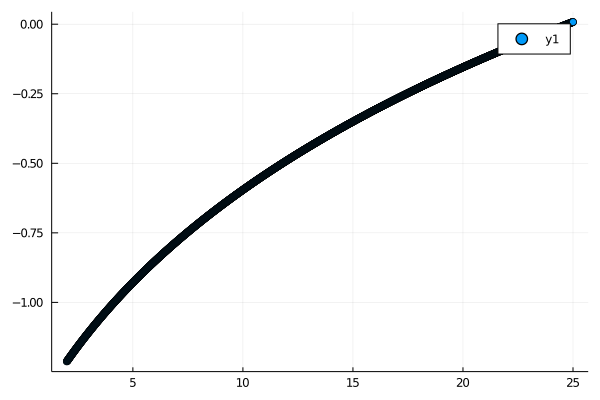

In [204]:
stability1 = stability_trajectory(roots[1], 2, 25, 0.01)
scatter(range(2, 25, step=0.01), stability1)

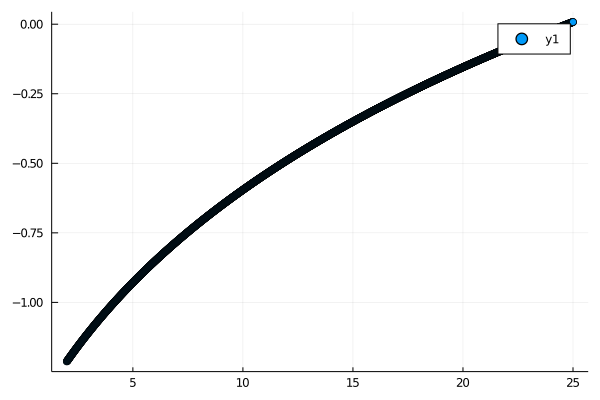

In [206]:
stability2 = stability_trajectory(roots[2], 2, 25, 0.01)
scatter(range(2, 25, step=0.01), stability2)

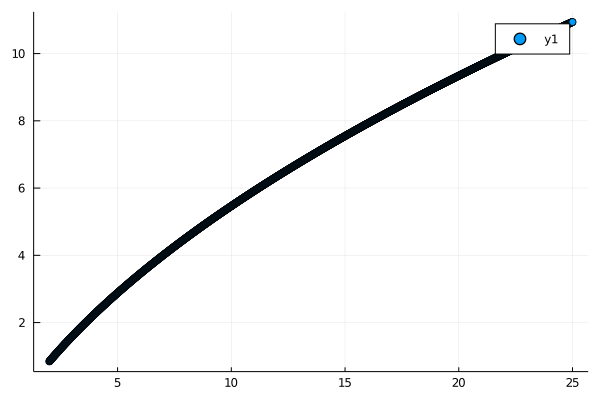

In [207]:
stability3 = stability_trajectory(roots[3], 2, 25, 0.01)
scatter(range(2, 25, step=0.01), stability3)

In [220]:
function find_ρ(stability)
    ρs = range(2, 25, step=0.01)
    for i in 1:length(ρs) - 1
        if stability[i] < 0 && stability[i+1] > 0
            return ρs[i]
        end
    end
    return missing
end

find_ρ (generic function with 1 method)

In [221]:
ρ1 = find_ρ(stability1)

24.73

In [222]:
ρ2 = find_ρ(stability2)

24.73

In [ ]:
ρ3 = find_ρ(stability)